# Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
import numpy as np



#Read in data.  Zipcode is string to keep leading 0's
raw_data = pd.read_csv('Zillow_data/zhvi_all-homes_zipcode.csv', dtype={'RegionName': object})
raw_data.head(3)

,RegionID,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,...,2019-09-30,2019-10-31,2019-11-30,2019-12-31,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30
0,61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,233265.0,...,1248340.0,1234262.0,1229890.0,1226466.0,1208024.0,1182758.0,1150900.0,1134880.0,1120949.0,1112549.0
1,84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,211748.0,...,494425.0,493485.0,492514.0,491726.0,491562.0,492618.0,494017.0,494766.0,494546.0,494435.0
2,61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,245773.0,...,1161916.0,1153259.0,1156287.0,1175142.0,1193746.0,1205413.0,1203165.0,1209735.0,1211403.0,1212520.0


In [2]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30443 entries, 0 to 30442
Columns: 303 entries, RegionID to 2020-06-30
dtypes: float64(294), int64(2), object(7)
memory usage: 70.4+ MB


Imported data as Pandas DataFrame and stored in raw_data variable.  raw_data is in Wide format.

# Cleaning & Preprocessing Functions

In [3]:
def melt_data(df):
    """
    Turn DataFrame from Wide to Long Format
    
    Arguments:
    df -- Pandas DataFrame with dates in Wide format
    
    Return:
    Pandas DataFrame in Long format.
    """
    melted = pd.melt(df, id_vars=['zipcode', 'City', 'State', 'CountyName', 'Metro'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted

In [4]:
def clean_data(df):
    """
    Clean DataFrame.  Rename columns, drop unneeded columns, fill missing Metro values, and transform to Long format.
    
    Arguments:
    df -- Pandas DataFrame in Wide format.
    
    Return:
    Cleaned and melted Pandas DataFrame
    """
    #rename RegionName to 'zipcode'
    df.rename(columns={'RegionName': 'zipcode'}, inplace=True)
    
    #drop unneeded columns
    df.drop(columns=['RegionID', 'RegionType', 'StateName', 'SizeRank'], inplace=True)
    
    #Change to long format
    df_long = melt_data(df)
    
    #Non-metro zipcodes now called 'rural'
    df_long.fillna('rural', inplace=True)
    
    return df_long

# Processing & Visualization Functions

In [5]:
def get_codes_data(df, codes):
    """
    Filter DataFrame to show certain zipcodes.
    
    Arguments:
    df -- cleaned Pandas DataFrame in Long format.
    codes -- list of zipcodes to keep in output DataFrame.
    
    Return:
    Pandas DataFrame containing data for the zipcodes contained in 'codes'
    """
    #Filter df to keep data for selected zipcodes
    top_df = df[df['zipcode'].isin(codes)]
    
    #Filter out data from 2020.
    top_df = df.loc[df['time'].dt.year != 2020]
    
    #Set time as index
    top_df.set_index('time', inplace=True)
    
    #Drop unneeded columns
    top_df = top_df[['zipcode', 'value']]
    
    return top_df

In [6]:
def split_data_by_code(top_df, codes):
    """
    Split DataFrame into smaller DataFrames, each containing data for one zipcode.
    
    Arguments:
    top_df -- DataFrame containing data for zipcodes you want to separate.
    codes -- list of zipcodes.  A DataFrame will be created for each item in the list.
    
    Return:
    List of DataFrames where each DataFrame corresponds to data from one zipcode contained in 'codes'
    """
    df_list = []
    for i in range(len(codes)):
        df_list.append(top_df.loc[top_df['zipcode'] == codes[i]].drop('zipcode', axis=1))
        
    return df_list

In [7]:
def ts_train_test_split(df_list, train_percent):
    """
    Split each DataFrame in df_list into train and test sets.
    
    Arguments:
    df_list -- list of DataFrames, each containing data for one zipcode
    train_percent -- float representing the % of data that should be allocated to the training set.
    
    Return:
    train_list -- list of DataFrames, each containing training data for one zipcode
    test_list -- list of DataFrames, each containing test data for one zipcode
    """
    train_list = []
    test_list = []
    
    for i in range(len(df_list)):
        train = df_list[i][:round(df_list[i].shape[0]*train_percent)]
        train_list.append(train)
        
        test = df_list[i][round(df_list[i].shape[0]*train_percent):]
        test_list.append(test)
    
    return train_list, test_list

In [8]:
def plot_trends(df_list, codes):
    """
    Plot line graphs for DataFrames contained in df_list.
    
    Arguments:
    df_list -- list of DataFrames, each containing data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'df_list'
    
    Return:
    No return value.  Prints a line graph.
    """
    for i in range(len(codes)):
        df_list[i]['value'].plot(label=codes[i], figsize=(15, 6))
        plt.legend()

# Modeling Functions

In [9]:
def get_difference(df_list):
    """
    Perform 2 orders of differencing on each DataFrame in a list of DataFrames.
    
    Arguments:
    df_list -- list of DataFrames, each containing data for one zipcode
    
    Return:
    list of DataFrames, each containing twice differenced data for one zipcode
    """
    df_diff = []
    for code in df_list:
        df_diff.append(code['value'].diff().diff().dropna())

    return df_diff

In [10]:
def plot_diff_trends(diff_list, codes):
    """
    Plot line graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing differenced data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints a line graph.
    """
    #Graph trends
    for i in range(len(codes)):
        diff_list[i].plot(label=codes[i], figsize=(15, 6))
        plt.legend()

In [11]:
def decompose_graphs(diff_list, codes):
    """
    Plot decomposition graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing differenced data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints a decomposition graph for each element in diff_list.
    """
    for i in range(len(codes)):
        decomposition = seasonal_decompose(diff_list[i])
        print(codes[i] + ": ")
        fig = plt.figure()
        fig = decomposition.plot()
        fig.set_size_inches(15, 8)

In [12]:
def test_stationarity(timeseries, window):
    """
    Test the stationarity of time series data contained in a DataFrame and print/graph results.
    
    Arguments:
    timeseries -- DataFrame containing time series data
    window -- Integer - the length of time over which to test stationarity
    
    Return:
    N/A.  Prints and graphs results of Dickey Fuller test.
    """

    # Determing rolling statistics
    rolmean = timeseries.rolling(window=window).mean()
    rolstd = timeseries.rolling(window=window).std()

    # Plot rolling statistics:
    fig = plt.figure(figsize=(12, 8))
    orig = plt.plot(timeseries.iloc[window:], color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=[
                         'Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [13]:
def test_station_of_list(diff_list, window):
    """
    Test the stationarity of multiple DataFrames.
    
    Arguments:
    diff_list -- list of DataFrames containing time series data
    window -- Integer - the length of time over which to test stationarity
    
    Return:
    N/A.  Prints and graphs results of Dickey Fuller test for each DataFrame in diff_list.
    """
    for i in range(len(diff_list)):
        test_stationarity(diff_list[i], window)
        

In [14]:
def plot_all_pacf(diff_list, codes):
    """
    Plot PACF graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints a PACF graph for each element in diff_list.
    """
    for i in range(len(diff_list)):
        plot_pacf(diff_list[i], title= "PACF for Zipcode " + codes[i]);

In [15]:
def plot_all_acf(diff_list, codes):
    """
    Plot ACF graphs for DataFrames contained in diff_list.
    
    Arguments:
    diff_list -- list of DataFrames, each containing data for one zipcode
    codes -- list of zipcodes, each corresponding to one element in 'diff_list'
    
    Return:
    No return value.  Prints an ACF graph for each element in diff_list.
    """
    for i in range(len(diff_list)):
        plot_acf(diff_list[i], title="ACF for Zipcode " + codes[i]);

In [36]:
def fit_arima(data, model_list, pred_list, ar, diff, ma):
    """
    Fit an ARIMA model on time series data in a DataFrame.  Store model and make predictions.
    
    Arguments:
    data -- DataFrame containing time series data ready for model fitting.
    model_list -- list of models to store the model in.  Can be empty.
    pred_list -- list of predictions to store the predictions in.  Can be empty.
    ar -- Integer - the AutoRegressive term taken as input for the ARIMA model.
    diff -- Integer - the order of differencing term taken as input for the ARIMA model.
    ma -- Integer - the MovingAverage term taken as input for the ARIMA model.
    
    Return:
    model_list -- updated version of the input list containing the new fitted model object.
    pred_list -- updated version of the input list containing a DataFrame of the predictions generated by the model.
    """
#     model_data = data.drop('zipcode', axis=1)
    model = ARIMA(data, (ar,diff,ma)).fit()
    model_list.append(model)
    pred_list.append(model.predict(typ='levels'))
    
    return model_list, pred_list

# Data Cleaning

In [17]:
df = clean_data(raw_data)

Melted data into long format for proper time series analysis.  Removed unneeded columns and properly named the 'zipcode' column.  Replaced missing 'Metro' values with 'rural'.

# Modeling - Top 5 Codes Since 1996

### Preprocessing & Viz

In [18]:
codes_full_range = ['91108', '90211', '90027', '94610', '90048']
top_full_range = get_codes_data(df, codes_full_range)
fr_list = split_data_by_code(top_full_range, codes_full_range)

Filtered down raw_data to only contain data for specific zipcodes.  The zipcodes are those where median prices have increased the most in the time range 1996-2019.  Then separated out data for each zipcode so that it can be analyzed and graphed separately.  These separated DataFrames are stored in fr_list.

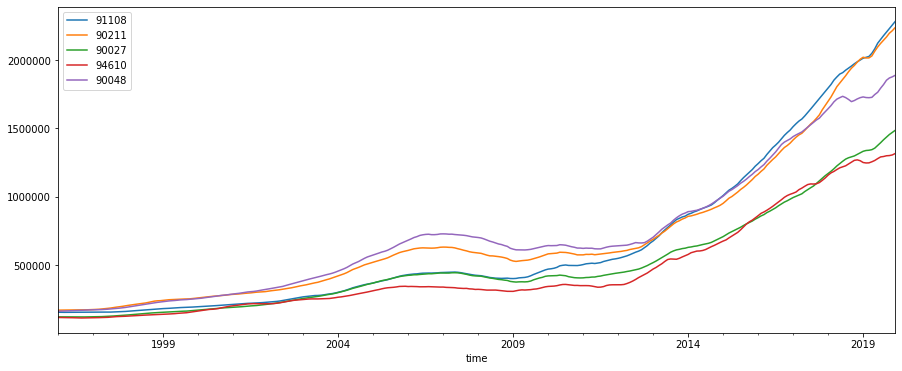

In [19]:
plot_trends(fr_list, codes_full_range)

Visualize how median value changes over time for the top 5 zipcodes.

### Assumptions & Best Parameters

In [20]:
fr_train, fr_test = ts_train_test_split(fr_list, 0.71)

Here we split each dataframe in fr_list into train and test sets.  This allows for model validation at the end of the process.

In [21]:
fr_train_log = []
for i in range(len(fr_train)):
    log_df = pd.DataFrame(np.log(fr_train[i]['value']))
    fr_train_log.append(log_df)

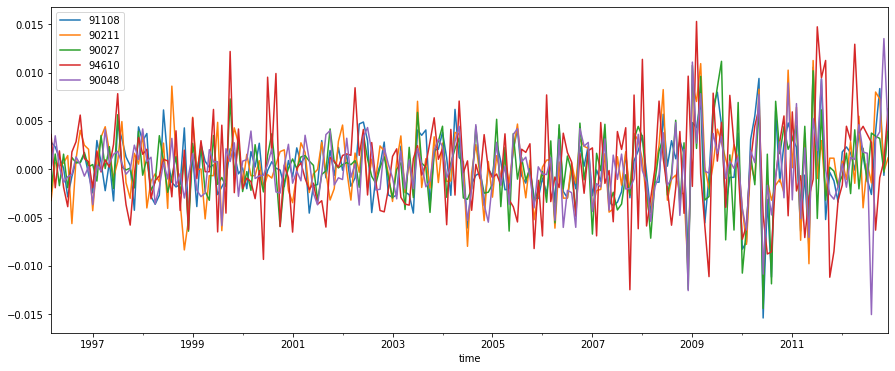

In [22]:
fr_diff = get_difference(fr_train_log)
plot_diff_trends(fr_diff, codes_full_range)

The unaltered data contained in fr_list was not stationary.  Stationarity is a requirement for most time series modeling and analysis.  To correct this we transform the data using 2 orders of differencing.  This differenced data is stored in fr_diff.  Then, to visually inspect the stationarity, we plot the newly differenced data over time.

In [24]:
test_station_of_list(fr_diff, 12)

The visual inspection of stationarity in the previous step looked promising, but is not enough to make a conclusion on.  In this step we conduct a Dickey-Fuller test for the data of each zipcode contained in fr_diff.  The p-values below the threshold of 0.05 allows us to **reject** the null hypothesis that our data is **not** stationary.

In [ ]:
plot_all_pacf(fr_diff, codes_full_range)

These graphs show partial autocorrelation for the differenced data of each zipcode.  The values outside of the confidence interval give us a starting point for AR parameters to try when fitting our ARIMA model.

In [ ]:
ar_values = [0, 2, 3, 6, 12]
best_ar_values = []

for i in range(len(fr_train_log)):
    for x in range(len(ar_values)):
        best_ar = 0
        best_aic = 9999999
        model = ARIMA(fr_train_log[i], (ar_values[x],2,1)).fit()
        if model.aic < best_aic:
            best_aic = model.aic
            best_ar = ar_values[x]
    print("Best AR Value is: " + str(best_ar))
    best_ar_values.append(best_ar)

An AR term of 12 in the ARIMA model results in the lowest AIC value for each zipcode.  We will use AR == 12 in all models.

In [ ]:
plot_all_acf(fr_diff, codes_full_range)

These graphs show autocorrelation for the differenced data of each zipcode.  The negative values outside of the confidence interval give us a starting point for MA parameters to try when fitting our ARIMA model.

In [34]:
ma_values = [0, 1, 3, 12]
best_ma_values = []

model = ARIMA(fr_train_log[0], (12,2,1)).fit()
model.aic

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)


-1796.1561362417065

Using AR parameter of 12 and MA parameter of 1 in our ARIMA model results in the lowest AIC score, so now we will fit our models with these parameters


## Model Fitting

In [38]:
model_list = []
log_pred_list = []

fit_arima(fr_train_log[0], model_list, log_pred_list, 12, 2, 1)
fit_arima(fr_train_log[1], model_list, log_pred_list, 12, 2, 1)
fit_arima(fr_train_log[2], model_list, log_pred_list, 12, 2, 1)
fit_arima(fr_train_log[3], model_list, log_pred_list, 12, 2, 1)
fit_arima(fr_train_log[4], model_list, log_pred_list, 12, 2, 1)

/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency M will be used.
  % freq, ValueWarning)
/Users/jamesfay/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/statsmodels/tsa/bas

([<statsmodels.tsa.arima_model.ARIMAResultsWrapper at 0x103ca7048>,
 [1996-03-31    11.936204
  1996-04-30    11.937629
  1996-05-31    11.941142
  1996-06-30    11.943458
  1996-07-31    11.946480
                  ...    
  2012-08-31    13.303856
  2012-09-30    13.320688
  2012-10-31    13.342219
  2012-11-30    13.374587
  2012-12-31    13.395967
  Freq: M, Length: 202, dtype: float64, 1996-03-31    12.044704
  1996-04-30    12.042064
  1996-05-31    12.043222
  1996-06-30    12.046256
  1996-07-31    12.047046
                  ...    
  2012-08-31    13.344719
  2012-09-30    13.354949
  2012-10-31    13.373965
  2012-11-30    13.401601
  2012-12-31    13.422932
  Freq: M, Length: 202, dtype: float64, 1996-03-31    11.695758
  1996-04-30    11.692703
  1996-05-31    11.692778
  1996-06-30    11.691505
  1996-07-31    11.690734
                  ...    
  2012-08-31    13.055451
  2012-09-30    13.073681
  2012-10-31    13.091398
  2012-11-30    13.114236
  2012-12-31    13.13175

In [39]:
codes_full_range

['91108', '90211', '90027', '94610', '90048']

In [40]:
#transform test data to match training

fr_test_log = []
for i in range(len(fr_test)):
    log_df = pd.DataFrame(np.log(fr_test[i]['value']))
    fr_test_log.append(log_df)

In [48]:
log_pred_list_test = []

for i in range(len(model_list)):
    test_pred = model_list[i].predict(start=fr_test_log[i].index[0], end=fr_test_log[i].index[-1],typ='levels')
    log_pred_list_test.append(test_pred)

## Final Model

## Model & Predictions for 91108

In [ ]:
# data_91108 is the dataframe containing all values/dates for zipcode 91108
data_91108 = fr_list[0]
data_91108.drop('zipcode', axis=1, inplace=True)
data_91108

In [ ]:
# In this step we are fitting the model and making predictions for the 91108 data
model_91108 = ARIMA(data_91108, (1,2,0)).fit()
predictions_91108 = model_91108.predict(typ='levels')

In [ ]:
#Summary for 91108 Model
model_91108.summary()

In [ ]:
# Predictions from the model
predictions_91108_df = pd.DataFrame(predictions_91108, columns=['value'])
predictions_91108_df